# Previsão de vendas

## Compreensão do Negócio

O objetivo desse prejeto é para a previsão de vendas para os próximos 7 dias, seja do montante total ou de algum item específico, os principais interessados nessa análise são o time de vendas e o financeiro, pois em cima dessa previsão conseguiremos melhorar o alinhamento entre a oferta e a demanda, além de reduzir o excesso de itens em estoque

# Compreensão dos Dados

## Imports

In [34]:
# Bibliotecas padrão
import pandas as pd
import numpy as np
from typing import Optional, Set

# Biblioteca para testes estatísticos
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf

# Bibliotecas de visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

## Funções

In [2]:
def converter_coluna_data(coluna: str, df: pd.DataFrame, formato='%Y-%m-%d') -> pd.Series:
    """Converte uma coluna para o tipo datetime, permitindo formatação personalizada.

    Args:
        coluna: Nome da coluna a ser convertida.
        df: DataFrame contendo a coluna.
        formato: Formato da data na coluna (default: '%Y-%m-%d').

    Returns:
        Série com as datas convertidas.
    """
    return pd.to_datetime(df[coluna], format=formato, errors='coerce')

def calcular_datas_completas(df: pd.DataFrame, coluna: str) -> pd.Series:
    """
    Retorna uma série de datas contínuas com base na data mínima e máxima de uma coluna do DataFrame.

    Args:
        df (pd.DataFrame): DataFrame contendo a coluna de datas.
        coluna (str): Nome da coluna que será usada para calcular o intervalo de datas.

    Returns:
        pd.Series: Série com o intervalo de datas contínuas.
    """
    return pd.date_range(start=df[coluna].min(), end=df[coluna].max())

def verificar_datas_ausentes(coluna: str, df: pd.DataFrame, item: Optional[int] = None) -> set[pd.Timestamp]:
    """
    Retorna um conjunto de datas ausentes em uma coluna do DataFrame, considerando uma frequência específica.

    Args:
        coluna (str): Nome da coluna contendo as datas a serem analisadas.
        df (pd.DataFrame): DataFrame contendo a coluna a ser analisada.
        item (Optional[str]): Valor específico da coluna 'item' para filtrar os dados antes da análise (opcional).

    Returns:
        Set[pd.Timestamp]: Conjunto de datas ausentes.
    """
    # Criando um indice continuo de datas
    datas_completas = calcular_datas_completas(df, coluna)
    # Filtrar os dados, se necessário
    if item is not None:
        df = df[df['item'] == item]

    return sorted(set(datas_completas) - set(df[coluna]))

def criar_coluna_dia_semana(coluna: str, df: pd.DataFrame) -> pd.Series:
    """
    Retorna uma série de dias da semana com base em uma coluna de data.

    Args:
        coluna (str): Nome da coluna contendo as datas a serem analisadas.
        df (pd.DataFrame): DataFrame contendo a coluna a ser analisada.

    Returns:
        Series: Série com dias da semana.
    """
    return df[coluna].dt.day_name()

def criar_coluna_mes(coluna: str, df: pd.DataFrame) -> pd.Series:
    """
    Retorna uma série de meses com base em uma coluna de data.

    Args:
        coluna (str): Nome da coluna contendo as datas a serem analisadas.
        df (pd.DataFrame): DataFrame contendo a coluna a ser analisada.

    Returns:
        Series: Série com os meses.
    """
    return df[coluna].dt.month_name()

def ordernar_coluna(coluna: str, df: pd.DataFrame, lista_ordem: list[str]) -> pd.Series:
    """
    Retorna uma série com uma ordenação categorica

    Args:
        coluna (str): Nome da coluna contendo as datas a serem analisadas.
        df (pd.DataFrame): DataFrame contendo a coluna a ser analisada.
        lista_ordem (list[str]): Lista contendo a ordem das categorias

    Returns:
        Series: Série com a ordenação categorica estabelecida.
    """
    return pd.Categorical(df[coluna], categories=lista_ordem, ordered=True)

def teste_adf(timeseries: pd.Series):
    print('Resultado teste Dickey-Fuller aumentado (ADF):')
    teste = adfuller(timeseries, autolag='AIC')
    resultado = pd.Series(
        teste[0:4],
        index=[
            'Estatística de teste',
            'p-valor',
            'Lags usados',
            'Número de observações'
        ],
    )
    for key, value in teste[4].items():
        resultado['Valor crítico (%s)' %key] = value
    print(resultado)

def teste_kpss(timeseries: pd.Series):
    print("Resultado teste KPSS:")
    kpssteste = kpss(timeseries, regression="c", nlags="auto")
    resultado = pd.Series(
        kpssteste[0:3], index=["Estatística do teste", "p-valor", "Lags usados"]
    )
    for key, value in kpssteste[3].items():
        resultado["Valor crítico (%s)" % key] = value
    print(resultado)

def autocorrelacao(series: pd.Series, lag: int) -> float:
    return series.autocorr(lag = lag)

## Carregando dataset

In [35]:
path = '/home/diegopaes/ml_projects/forecast/data/raw/vendas.csv'
df = pd.read_csv(path)

## Análise Exploratória dos Dados

### Tipo de variáveis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135226 entries, 0 to 135225
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   item        135226 non-null  int64 
 1   data_venda  135226 non-null  object
 2   venda       135226 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.1+ MB


#### Insights

Podemos verificar que a coluna data_venda não é do tipo datetime, para nos aprofundarmos nas análises será necessário fazer essa conversão para o tipo data


### Valores ausentes

In [7]:
df.head()

,item,data_venda,venda
0,336,2024-01-14,15
1,336,2024-01-18,28
2,336,2024-01-20,34
3,336,2024-01-23,32
4,336,2024-01-25,27


In [5]:
# Converte coluna data_venda para o tipo datetime
df['data_venda'] = converter_coluna_data('data_venda', df)

In [8]:
# Verifica se existe alguma data faltante no dataset completo
verificar_df_completo = verificar_datas_ausentes('data_venda', df)
# Verifica se existe alguma data faltante filtrando um item específico
verificar_df_item = verificar_datas_ausentes('data_venda', df, 336)

In [9]:
print('\nDiferença entre datas dataframe completo:')
print(verificar_df_completo)

print('\nDiferença entre datas dataframe filtrado:')
print(verificar_df_item)


Diferença entre datas dataframe completo:
[]

Diferença entre datas dataframe filtrado:
[Timestamp('2024-03-29 00:00:00'), Timestamp('2024-03-31 00:00:00')]


In [10]:
print('\nTotal vendas nulas:')
print(df.venda.isnull().sum())

print('\nTotal itens nulos:')
print(df.item.isnull().sum())


Total vendas nulas:
0

Total itens nulos:
0


#### Insights

O dataframe como um todo não possui datas faltantes, contudo se filtrarmos os itens vemos que ocorre a falta de algumas datas, sendo necessário um tratamento antes de fazer uma previsão. Já as colunas de "venda" e "item" podemos constatar que não existem valores nulos

### Análise Exploratória

#### Total Itens

In [11]:
df.item.nunique()

5696

#### Total de Dias

In [12]:
print(f'Data mínima: {df.data_venda.min()}\nData máxima: {df.data_venda.max()} \nTotal datas únicas: {df.data_venda.nunique()}')

Data mínima: 2024-01-14 00:00:00
Data máxima: 2024-04-08 00:00:00 
Total datas únicas: 86


In [13]:
df.shape

(135226, 3)

##### Insights

Existe um total de 5696 itens únicos em nosso dataset e 86 dias seguidos começando em 14/01/2024 e terminando 08/04/2024, como existem datas ausentes quando olhamos as informações por itens precisamos garantir que as datas estejam completas, após o tratamento teremos um total de 489.856 registros, ou seja, teremos 354.630 registros a mais


#### Análise por Itens

In [14]:
print(f'Itens totais vendidos: {df.venda.sum()}')

Itens totais vendidos: 3523953


In [15]:
# Calcular a soma total de vendas por SKU
vendas_por_item = df.groupby('item')['venda'].sum().sort_values(ascending=False)

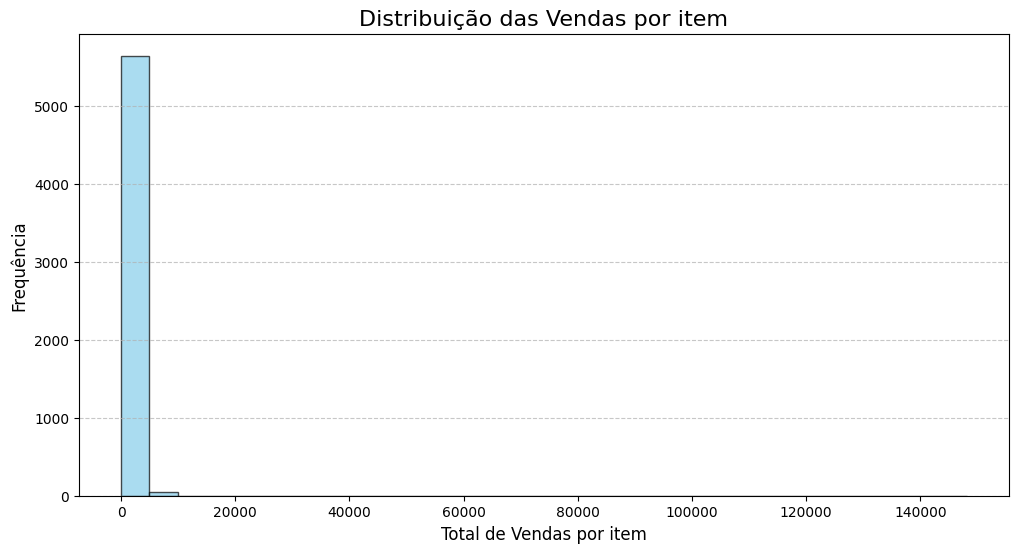

In [16]:
# Plotar a distribuição das vendas
plt.figure(figsize=(12, 6))
plt.hist(vendas_por_item, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribuição das Vendas por item', fontsize=16)
plt.xlabel('Total de Vendas por item', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [17]:
# Exibir os 10 SKUs mais vendidos
print('Top 10 itens com maior volume de vendas:')
print(vendas_por_item.head(10))

Top 10 itens com maior volume de vendas:
item
535    148122
536     42925
537     26676
383      9979
257      9670
206      9452
267      9055
299      8850
522      8631
93       8426
Name: venda, dtype: int64


In [18]:
# Exibir os 10 SKUs mais vendidos
print("Top 10 itens com menor volume de vendas:")
print(vendas_por_item.tail(10))

Top 10 itens com menor volume de vendas:
item
3909    10
2689    10
4773    10
4771    10
2192    10
3797    10
3788    10
5379    10
5387    10
5406    10
Name: venda, dtype: int64


##### Insights

Podemos observar que, exceto pelos itens 535, 536 e 537, todos os outros itens apresentaram vendas inferiores a 10 mil unidades no período analisado. Esses três itens, por sua vez, representam 6% das vendas totais, destacando-se com volumes de venda significativamente maiores do que os demais, embora correspondam a uma pequena parcela do total. Esse comportamento fica evidente no histograma, onde o gráfico apresenta forte assimetria à direita, indicando que os valores mais elevados de vendas são raros. Além disso, verificamos que os 10 itens com menores vendas totalizaram apenas 10 unidades, o que levanta a necessidade de avaliar a viabilidade de manter sua comercialização.


#### Análise por dia

In [19]:
df['dia_semana'] = criar_coluna_dia_semana('data_venda', df)
df['mes'] = criar_coluna_mes('data_venda', df)

In [20]:
df_dia_semana = df.groupby(['dia_semana', 'mes'])[['venda']].sum().reset_index()

In [21]:
dias_ordem = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mes_ordem = ['January', 'February', 'March', 'April']
df_dia_semana['dia_semana'] = ordernar_coluna('dia_semana', df_dia_semana, dias_ordem)
df_dia_semana['mes'] = ordernar_coluna('mes', df_dia_semana, mes_ordem)

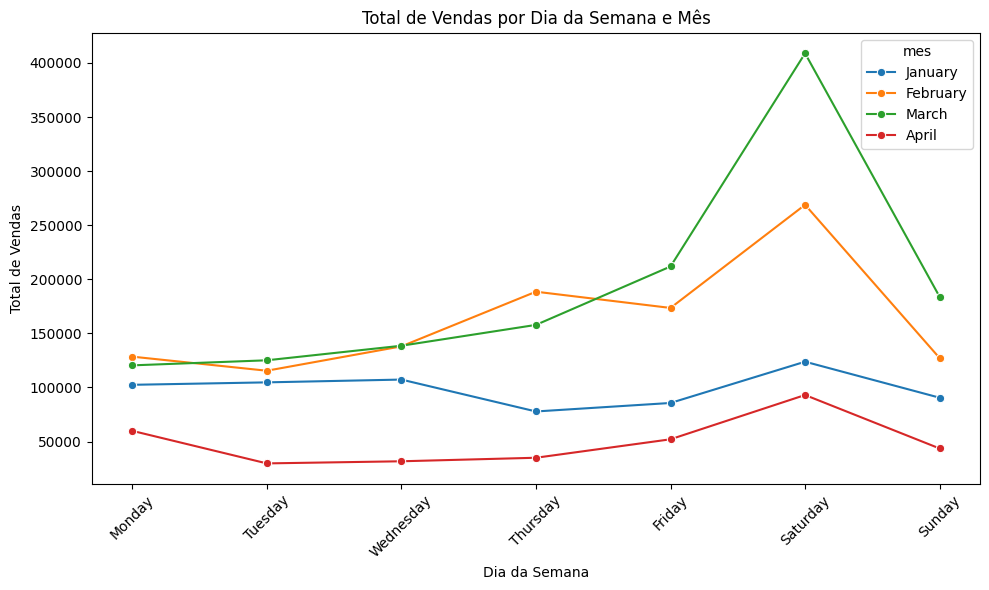

In [22]:
# Cria o gráfico de linhas
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_dia_semana, x='dia_semana', y='venda', hue='mes', marker='o')

# Ajuste visual
plt.title('Total de Vendas por Dia da Semana e Mês')
plt.xlabel('Dia da Semana')
plt.ylabel('Total de Vendas')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

##### Insights

Podemos identificar que em todos os meses sempre há um crescimento nas vendas as sextas-feira e aos sábados e no domingo tendo uma queda nas venda mantendo um valor próximo as vendas das sextas.


#### Estacionariedade

In [23]:
# Calcular a soma total de vendas por data
venda_data = df.groupby(['data_venda'])[['venda']].sum().reset_index()
venda_data = venda_data.sort_values('data_venda')

In [24]:
# Calcular a média móvel diretamente para toda a coluna 'venda' (janela de 5)
venda_data['media_movel_5'] = venda_data['venda'].rolling(window=5, min_periods=1).mean()

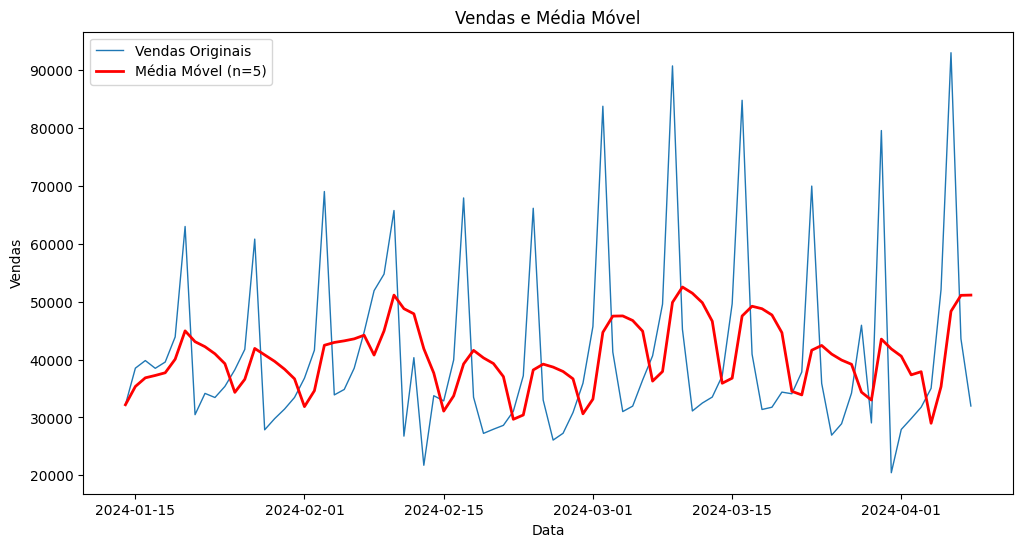

In [25]:
# Plotar as vendas e a média móvel
plt.figure(figsize=(12, 6))
plt.plot(venda_data['data_venda'], venda_data['venda'], label='Vendas Originais', linewidth=1)
plt.plot(venda_data['data_venda'], venda_data['media_movel_5'], label='Média Móvel (n=5)', color='red', linewidth=2)
plt.title("Vendas e Média Móvel")
plt.xlabel("Data")
plt.ylabel("Vendas")
plt.legend()
plt.show()

In [26]:
# Copia o dataframe original
df1 = df.copy()
# Adiciona a data como indíce para o dataframe
df1 = df1.set_index('data_venda')

In [27]:
teste_kpss(df1.venda)

Resultado teste KPSS:
Estatística do teste      0.172744
p-valor                   0.100000
Lags usados             196.000000
Valor crítico (10%)       0.347000
Valor crítico (5%)        0.463000
Valor crítico (2.5%)      0.574000
Valor crítico (1%)        0.739000
dtype: float64


##### Insights

Pelo teste KPSS, observamos que o p-valor é maior que 0,05. Assim, podemos concluir que a série é estacionária. Realizar testes para verificar a estacionariedade é essencial, pois, em uma série estacionária, as propriedades estatísticas não mudam ao longo do tempo. Alguns modelos, como ARIMA e SARIMA, assumem que a série é estacionária para produzir previsões adequadas.

Idealmente, seria interessante rodar também o teste de Dickey-Fuller Aumentado (ADF). A combinação dos dois testes nos permitiria chegar a uma conclusão mais robusta. Ainda assim, pelo gráfico, observa-se que o comportamento das vendas segue um padrão aproximadamente constante. Caso fosse aplicado o teste ADF, estas seriam as possíveis combinações de resultados e as ações recomendadas:

1. **Ambos os testes concluem que a série não é estacionária:**
A série não é estacionária.

2. **Ambos os testes concluem que a série é estacionária:**
A série é estacionária.

3. **KPSS indica estacionariedade, mas ADF indica não estacionariedade:**
A série apresenta tendência estacionária. Nesse caso, é necessário remover a tendência para torná-la estritamente estacionária. Após o ajuste, verifica-se novamente se a nova série é estacionária.

4. **KPSS indica não estacionariedade, mas ADF indica estacionariedade:**
A série é estacionária nas diferenças. É necessário calcular a diferença da série para garantir estacionariedade. Em seguida, verifica-se novamente se a nova série é estacionária.

Para o gráfico podemos ver um comportamento ciclíco, com picos regulares de vendas, esses picos muito provavelmente se dão as sextas-feita e sábados como vimos anteriormente. Esse comportamente cíclico das vendas fica evidente com a média móvel, essa média sugere uma estabilidade na tendência geral, com valores oscilando próximos de um intervalo relativamente fixo


#### Autocorrelação

##### Autocorrelação lag=7

In [28]:
print(f"Autocorrelação com lag 7: {round(autocorrelacao(df['venda'], 7),2)}")

Autocorrelação com lag 7: 0.49


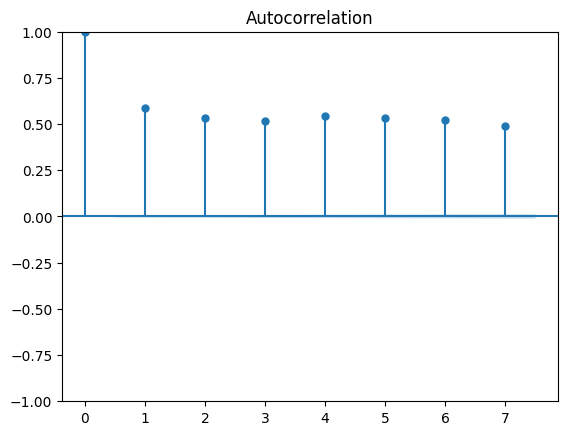

In [29]:
plot_acf(df['venda'], lags=7) 
plt.show()

##### Autocorrelacao lag=15

In [30]:
print(f"Autocorrelação com lag 15: {round(autocorrelacao(df['venda'], 15),2)}")

Autocorrelação com lag 15: 0.36


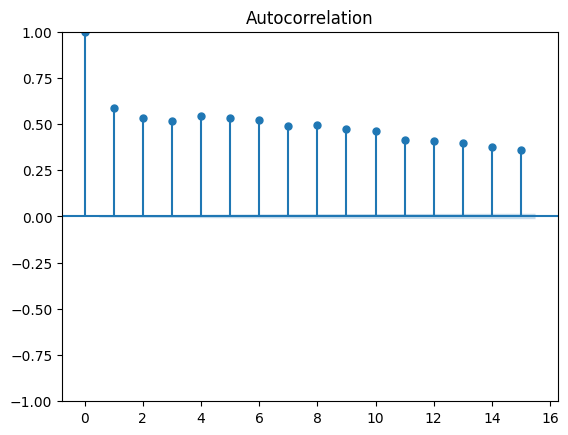

In [31]:
plot_acf(df['venda'], lags=15) 
plt.show()

##### Autocorrelação lag=30

In [32]:
print(f"Autocorrelação com lag 30: {round(autocorrelacao(df['venda'], 30),2)}")

Autocorrelação com lag 30: 0.15


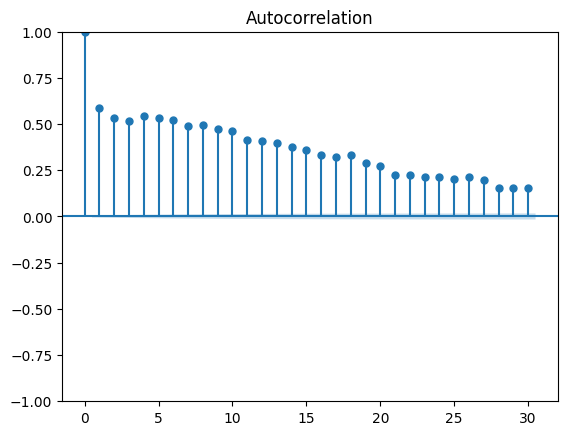

In [33]:
plot_acf(df['venda'], lags=30) 
plt.show()

##### Insights

Podemos ver que existe uma autocorrelação moderada para entre as vendas de um dia e as vendas ocorridas 7 dias antes, isso pode indicar um comportamento semanal repetitivo, podemos perceber picos uniformes no gráfico de autocorrelação para 7 dias o que reforça a ideia de uma preiodicidade semanal. Quando formos rodar os modelos ARIMA e SARIMA devemos considerar a incluir um componente de sazonalidade semanal. Para os demais gráficos podemos ver que a autocorrelação é fraca, principalmente para 30 dias.